In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error

import geopandas as gpd
from fiona.crs import from_epsg
import shapely
import urllib.request
import requests
import json
import os

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv("masterCardGrowth1201to1612.csv")
df.head()

,zipcode,growth201201,growth201202,growth201203,growth201204,growth201205,growth201206,growth201207,growth201208,growth201209,...,growth201603,growth201604,growth201605,growth201606,growth201607,growth201608,growth201609,growth201610,growth201611,growth201612
0,11436,8.0,4.0,38.0,14.0,26.0,37.0,78.0,860.0,985.0,...,389.0,354.0,73.0,699.0,179.0,247.0,72.0,155.0,649.0,327.0
1,11213,176.0,240.0,459.0,293.0,410.0,612.0,358.0,743.0,652.0,...,693.0,830.0,596.0,846.0,824.0,830.0,755.0,659.0,568.0,554.0
2,11212,339.0,103.0,319.0,293.0,260.0,404.0,413.0,729.0,170.0,...,918.0,894.0,840.0,937.0,899.0,916.0,884.0,897.0,881.0,772.0
3,11225,87.0,88.0,103.0,63.0,147.0,433.0,631.0,464.0,466.0,...,725.0,692.0,559.0,532.0,680.0,606.0,676.0,662.0,702.0,793.0
4,11218,106.0,178.0,149.0,80.0,110.0,169.0,585.0,707.0,840.0,...,174.0,752.0,516.0,693.0,453.0,565.0,569.0,704.0,709.0,520.0


In [3]:
for i in range(1,21):
    year = (i-1) // 4 + 2012
    quarter = i % 4
    if quarter == 0:
        quarter = 4
#     print(year, quarter)
    df[str(year) + str(quarter)] = df.iloc[:,(3*i-2):3*i+1].mean(axis=1)

In [4]:
df.shape

(248, 81)

In [5]:
df_quarter = df.drop(df.columns[1:61],axis=1)

In [6]:
df_quarter.head()

,zipcode,20121,20122,20123,20124,20131,20132,20133,20134,20141,...,20143,20144,20151,20152,20153,20154,20161,20162,20163,20164
0,11436,16.666667,25.666667,641.000000,992.333333,988.333333,985.333333,834.666667,330.333333,355.333333,...,624.333333,201.000000,534.333333,188.333333,622.333333,580.000000,328.000000,375.333333,166.000000,377.000000
1,11213,291.666667,438.333333,584.333333,568.333333,716.000000,463.000000,506.666667,629.000000,448.500000,...,563.333333,537.666667,772.333333,816.666667,834.666667,798.666667,631.333333,757.333333,803.000000,593.666667
2,11212,253.666667,319.000000,437.333333,391.333333,342.666667,499.666667,444.000000,414.666667,404.666667,...,352.333333,369.333333,488.000000,573.666667,625.000000,669.666667,807.666667,890.333333,899.666667,850.000000
3,11225,92.666667,214.333333,520.333333,413.666667,521.000000,626.333333,422.666667,375.000000,294.000000,...,285.333333,351.000000,484.000000,547.333333,783.333333,814.000000,661.666667,594.333333,654.000000,719.000000
4,11218,144.333333,119.666667,710.666667,722.000000,774.666667,806.666667,609.000000,521.333333,503.666667,...,140.666667,109.000000,147.000000,94.666667,426.000000,387.666667,406.666667,653.666667,529.000000,644.333333


In [7]:
df_quarter.dropna(inplace=True)

In [8]:
df_quarter.shape

(201, 21)

In [9]:
df_quarter.to_csv("mastercard_quarter.csv")

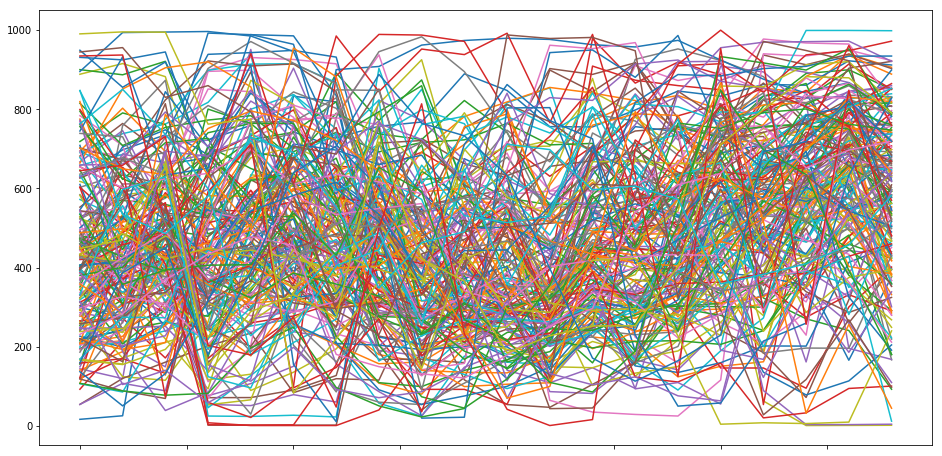

In [10]:
fig, ax = plt.subplots(figsize=(16,8))
df_quarter.iloc[:,1:].T.plot(ax=ax, legend=False)
plt.show()

In [11]:
X = df_quarter.iloc[:,1:]
mean = X.mean(axis=1)
std = X.std(axis=1)
X = X.apply(lambda x: (x - mean) / std)
range_n_clusters = range(2,8)
X.reset_index(drop=True, inplace=True)
X.head(2)

,20121,20122,20123,20124,20131,20132,20133,20134,20141,20142,20143,20144,20151,20152,20153,20154,20161,20162,20163,20164
0,-1.55218,-1.522795,0.486267,1.633370,1.620310,1.610515,1.118588,-0.528059,-0.446434,0.597277,0.431850,-0.950332,0.138001,-0.991689,0.425320,0.287102,-0.535677,-0.381134,-1.064607,-0.375692
1,-2.16487,-1.186021,-0.211621,-0.318404,0.667119,-1.021396,-0.729966,0.086484,-1.118168,-0.331752,-0.351774,-0.523073,1.043086,1.338966,1.459097,1.218834,0.102056,0.942977,1.247755,-0.149330


In [12]:
for n_clusters in range_n_clusters:
    km = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {}, the average silhouette_score is : {}".format(
        n_clusters, silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.1520811773638655
For n_clusters = 3, the average silhouette_score is : 0.14232955611730713
For n_clusters = 4, the average silhouette_score is : 0.1385547311976564
For n_clusters = 5, the average silhouette_score is : 0.14172810269225306
For n_clusters = 6, the average silhouette_score is : 0.12563879673449013
For n_clusters = 7, the average silhouette_score is : 0.12846886666023077


In [13]:
def plotting_km_cluster(n_clusters):
    #take in num of clustering, do k-means clustering,
    #return clustering plotting
    KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=999)
    KM.fit(X)
    centers = KM.cluster_centers_
    labels = KM.labels_
    year = range(1, 21)
    
    #plot
    fig = plt.figure(figsize=(3*2,n_clusters))
    for i in range(n_clusters):
        ax = fig.add_subplot(n_clusters,1,i+1)
        ax.set_ylabel(i, fontsize=20, rotation=0)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        plt.xticks([], [])
        plt.yticks([], [])
        for j in range(len(labels)):
            if labels[j] == i:
                plt.plot(year, X.iloc[j], alpha=0.6, color='grey', lw=4.0)
        plt.plot(year, centers[i], color='yellow', lw=4.0)
    plt.show()

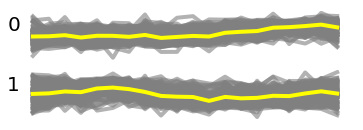

In [14]:
plotting_km_cluster(2)

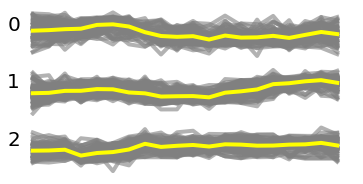

In [15]:
plotting_km_cluster(3)

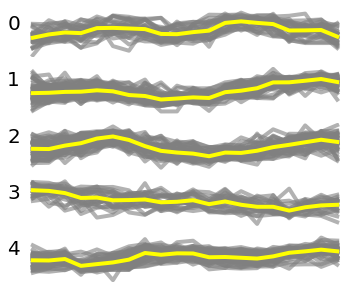

In [16]:
plotting_km_cluster(5)

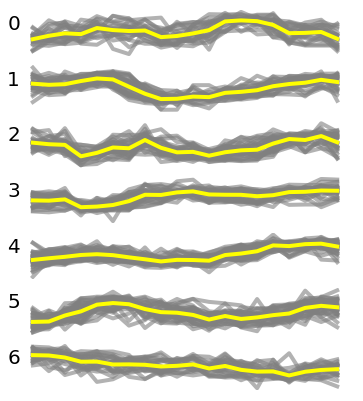

In [17]:
plotting_km_cluster(7)

In [18]:
df_quarter.head()

,zipcode,20121,20122,20123,20124,20131,20132,20133,20134,20141,...,20143,20144,20151,20152,20153,20154,20161,20162,20163,20164
0,11436,16.666667,25.666667,641.000000,992.333333,988.333333,985.333333,834.666667,330.333333,355.333333,...,624.333333,201.000000,534.333333,188.333333,622.333333,580.000000,328.000000,375.333333,166.000000,377.000000
1,11213,291.666667,438.333333,584.333333,568.333333,716.000000,463.000000,506.666667,629.000000,448.500000,...,563.333333,537.666667,772.333333,816.666667,834.666667,798.666667,631.333333,757.333333,803.000000,593.666667
2,11212,253.666667,319.000000,437.333333,391.333333,342.666667,499.666667,444.000000,414.666667,404.666667,...,352.333333,369.333333,488.000000,573.666667,625.000000,669.666667,807.666667,890.333333,899.666667,850.000000
3,11225,92.666667,214.333333,520.333333,413.666667,521.000000,626.333333,422.666667,375.000000,294.000000,...,285.333333,351.000000,484.000000,547.333333,783.333333,814.000000,661.666667,594.333333,654.000000,719.000000
4,11218,144.333333,119.666667,710.666667,722.000000,774.666667,806.666667,609.000000,521.333333,503.666667,...,140.666667,109.000000,147.000000,94.666667,426.000000,387.666667,406.666667,653.666667,529.000000,644.333333


In [19]:
df_quarter["average"] = df_quarter.iloc[:,1:].mean(axis=1)
df_quarter.head()

,zipcode,20121,20122,20123,20124,20131,20132,20133,20134,20141,...,20144,20151,20152,20153,20154,20161,20162,20163,20164,average
0,11436,16.666667,25.666667,641.000000,992.333333,988.333333,985.333333,834.666667,330.333333,355.333333,...,201.000000,534.333333,188.333333,622.333333,580.000000,328.000000,375.333333,166.000000,377.000000,492.066667
1,11213,291.666667,438.333333,584.333333,568.333333,716.000000,463.000000,506.666667,629.000000,448.500000,...,537.666667,772.333333,816.666667,834.666667,798.666667,631.333333,757.333333,803.000000,593.666667,616.041667
2,11212,253.666667,319.000000,437.333333,391.333333,342.666667,499.666667,444.000000,414.666667,404.666667,...,369.333333,488.000000,573.666667,625.000000,669.666667,807.666667,890.333333,899.666667,850.000000,514.616667
3,11225,92.666667,214.333333,520.333333,413.666667,521.000000,626.333333,422.666667,375.000000,294.000000,...,351.000000,484.000000,547.333333,783.333333,814.000000,661.666667,594.333333,654.000000,719.000000,490.183333
4,11218,144.333333,119.666667,710.666667,722.000000,774.666667,806.666667,609.000000,521.333333,503.666667,...,109.000000,147.000000,94.666667,426.000000,387.666667,406.666667,653.666667,529.000000,644.333333,449.266667


In [20]:
df_quarter['zipcode'] = df_quarter['zipcode'].astype('str')

In [23]:
#urllib.request.urlretrieve('https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip', "file.gz")
#os.system("mv " + "file.gz " + os.getenv("PUIDATA"))
#os.system("unzip " + os.getenv("PUIDATA") + "/file.gz -d " + os.getenv("PUIDATA") + "/zipcode")
nyc = gpd.read_file(os.getenv("PUIDATA") + "/zipcode" + "/ZIP_CODE_040114.shp")
nyc.drop(['BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE', 'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN'], axis=1, inplace=True)
nyc.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [24]:
nyc = nyc.merge(df_quarter, left_on='ZIPCODE', right_on='zipcode')
nyc.drop(['zipcode'], axis=1, inplace=True)

In [25]:
nyc.head()

,ZIPCODE,geometry,20121,20122,20123,20124,20131,20132,20133,20134,...,20144,20151,20152,20153,20154,20161,20162,20163,20164,average
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",16.666667,25.666667,641.000000,992.333333,988.333333,985.333333,834.666667,330.333333,...,201.000000,534.333333,188.333333,622.333333,580.000000,328.000000,375.333333,166.000000,377.000000,492.066667
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",291.666667,438.333333,584.333333,568.333333,716.000000,463.000000,506.666667,629.000000,...,537.666667,772.333333,816.666667,834.666667,798.666667,631.333333,757.333333,803.000000,593.666667,616.041667
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",253.666667,319.000000,437.333333,391.333333,342.666667,499.666667,444.000000,414.666667,...,369.333333,488.000000,573.666667,625.000000,669.666667,807.666667,890.333333,899.666667,850.000000,514.616667
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",92.666667,214.333333,520.333333,413.666667,521.000000,626.333333,422.666667,375.000000,...,351.000000,484.000000,547.333333,783.333333,814.000000,661.666667,594.333333,654.000000,719.000000,490.183333
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",144.333333,119.666667,710.666667,722.000000,774.666667,806.666667,609.000000,521.333333,...,109.000000,147.000000,94.666667,426.000000,387.666667,406.666667,653.666667,529.000000,644.333333,449.266667


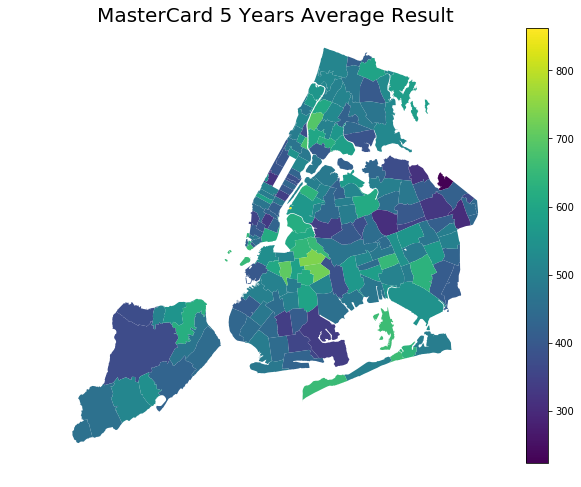

In [26]:
nyc = gpd.GeoDataFrame(nyc)
fig, ax = plt.subplots(figsize=(10,8))
nyc.plot(ax=ax, column='average', categorical=False, legend=True) 
ax.set_title('MasterCard 5 Years Average Result', fontsize=20)
ax.set_axis_off()
plt.show()

In [27]:
nyc.iloc[:,-1].to_csv("masterCard.csv")